# **Demo Uplift Modeling**

In this notebook, I will demo Uplift Modeling with several Python libraries including CausalML, Sklift, Pylift. I will also perform predictive techniques and conduct comparison between Predictive Modeling and Uplift Modeling. Finally, I will give several summary and reflection on how I implement this notebook, etc.

## **Load data**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklift.metrics import uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
from sklift.viz import plot_uplift_preds, plot_qini_curve, plot_uplift_by_percentile, plot_uplift_curve
from sklift.models import SoloModel, TwoModels
from sklearn.base import clone
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from causalml.inference.tree import UpliftRandomForestClassifier, UpliftTreeClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot
from IPython.display import Image
from causalml.inference.meta import BaseSClassifier, BaseTClassifier
from causalml.metrics import plot_gain

In [ ]:
'''
from google.colab import drive
drive.mount('/content/gdrive')
'''

"\nfrom google.colab import drive\ndrive.mount('/content/gdrive')\n"

**About dataset**

The dataset was created by The Criteo AI Lab .The dataset consists of 13M rows, each one representing a user with 12 features, a treatment indicator and 2 binary labels (visits and conversions). 

Positive labels mean the user visited/converted on the advertiser website during the test period (2 weeks). The global treatment ratio is 84.6%. It is usual that advertisers keep only a small control population as it costs them in potential revenue.

Following is a detailed description of the features:

* f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11: feature values (dense, float)

* treatment: treatment group (1 = treated, 0 = control)

* conversion: whether a conversion occured for this user (binary, label)

* visit: whether a visit occured for this user (binary, label)

* exposure: treatment effect, whether the user has been effectively exposed (binary)

In [ ]:
df = pd.read_csv(r'/home/khointn/Downloads/causalml-demo/criteo-uplift-v2.1.csv')
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


## **Exploratory Data Analysis (EDA)**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13979592 entries, 0 to 13979591
Data columns (total 16 columns):
 #   Column      Dtype  
---  ------      -----  
 0   f0          float64
 1   f1          float64
 2   f2          float64
 3   f3          float64
 4   f4          float64
 5   f5          float64
 6   f6          float64
 7   f7          float64
 8   f8          float64
 9   f9          float64
 10  f10         float64
 11  f11         float64
 12  treatment   int64  
 13  conversion  int64  
 14  visit       int64  
 15  exposure    int64  
dtypes: float64(12), int64(4)
memory usage: 1.7 GB


In [ ]:
df.isnull().sum()

f0            0
f1            0
f2            0
f3            0
f4            0
f5            0
f6            0
f7            0
f8            0
f9            0
f10           0
f11           0
treatment     0
conversion    0
visit         0
exposure      0
dtype: int64

In [ ]:
df.describe().round(2)

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
count,13979592.00,13979592.00,13979592.00,13979592.00,13979592.00,13979592.00,13979592.00,13979592.00,13979592.00,13979592.00,13979592.00,13979592.00,13979592.00,13979592.00,13979592.00,13979592.00
mean,19.62,10.07,8.45,4.18,10.34,4.03,-4.16,5.10,3.93,16.03,5.33,-0.17,0.85,0.00,0.05,0.03
std,5.38,0.10,0.30,1.34,0.34,0.43,4.58,1.21,0.06,7.02,0.17,0.02,0.36,0.05,0.21,0.17
min,12.62,10.06,8.21,-8.40,10.28,-9.01,-31.43,4.83,3.64,13.19,5.30,-1.38,0.00,0.00,0.00,0.00
25%,12.62,10.06,8.21,4.68,10.28,4.12,-6.70,4.83,3.91,13.19,5.30,-0.17,1.00,0.00,0.00,0.00
50%,21.92,10.06,8.21,4.68,10.28,4.12,-2.41,4.83,3.97,13.19,5.30,-0.17,1.00,0.00,0.00,0.00
75%,24.44,10.06,8.72,4.68,10.28,4.12,0.29,4.83,3.97,13.19,5.30,-0.17,1.00,0.00,0.00,0.00
max,26.75,16.34,9.05,4.68,21.12,4.12,0.29,12.00,3.97,75.30,6.47,-0.17,1.00,1.00,1.00,1.00


In [ ]:
def share_pivot(df, index_cols):
    pivot = pd.DataFrame(df[index_cols].value_counts()).sort_index()
    pivot.columns = ['#']
    pivot['share'] = np.round(pivot['#'] / len(df), 2)
    display(pivot)

In [ ]:
share_pivot(df = df, index_cols = ['treatment', 'conversion', 'visit', 'exposure'])

#  share
treatment conversion visit exposure                 
0         0          0     0          2016832   0.14
                     1     0            76042   0.01
          1          1     0             4063   0.00
1         0          0     0         11055129   0.79
                           1           250702   0.02
                     1     0           385634   0.03
                           1           154479   0.01
          1          1     0            13680   0.00
                           1            23031   0.00

In [ ]:
share_pivot(df, ['treatment', 'exposure'])

#  share
treatment exposure                 
0         0          2096937   0.15
1         0         11454443   0.82
          1           428212   0.03

In [ ]:
share_pivot(df, ['treatment', 'conversion'])

#  share
treatment conversion                 
0         0            2092874   0.15
          1               4063   0.00
1         0           11845944   0.85
          1              36711   0.00

In [ ]:
share_pivot(df, ['treatment', 'visit'])

#  share
treatment visit                 
0         0       2016832   0.14
          1         80105   0.01
1         0      11305831   0.81
          1        576824   0.04

## **Data Preparation**

We will use 'visit' as our main criterion for treatment effect

In [ ]:
train, test = train_test_split(
    df.drop(columns = ['conversion']),
    test_size = 0.3, 
    random_state = 42)

To handle imbalanced data, we perform undersampler technique as follow

In [ ]:
class DataUndersampler:
    """Makes dataframe balances by target columns within treatment groups"""
    
    def __init__(self, target_column):
        self.__target_column = target_column
    
    def __make_equal(self, df):
        target_0_count = np.sum(df[self.__target_column] == 0)
        target_1_count = np.sum(df[self.__target_column] == 1)
        
        if target_0_count == target_1_count:
            pass
        elif target_0_count > target_1_count:
            df = pd.concat([
                df[df[self.__target_column] == 0].sample(n = target_1_count, random_state = 1),
                df[df[self.__target_column] == 1]
            ], axis = 0)
        elif target_0_count < target_1_count:
            df = pd.concat([
                df[df[self.__target_column] == 0],
                df[df[self.__target_column] == 1].sample(n = target_0_count, random_state = 1)
            ], axis = 0)
        
        return df
    
    def transform(self, df):
        df_treatment_0 = df[df['treatment'] == 0].copy()
        df_treatment_1 = df[df['treatment'] == 1].copy()
        
        df_treatment_0 = self.__make_equal(df_treatment_0)
        df_treatment_1 = self.__make_equal(df_treatment_1)
        df = pd.concat([df_treatment_0, df_treatment_1], axis = 0)
        return df
        
    __call__ = transform

In [ ]:
train = DataUndersampler(target_column = 'visit')(train)

The train and test set after perform undersampling:

In [ ]:
share_pivot(train, ['treatment', 'visit'])

#  share
treatment visit               
0         0       56239   0.06
          1       56239   0.06
1         0      403710   0.44
          1      403710   0.44

In [ ]:
X_train = train.drop(columns = ['treatment' , 'visit', 'exposure'])
treatment_train = train['treatment']
y_train = train['visit']
exposure_train = train['exposure']

X_test = test.drop(columns = ['treatment', 'visit', 'exposure'])
treatment_test = test['treatment']
y_test = test['visit']
exposure_test = test['exposure']

Define metrics calculator:

In [ ]:
def get_metrics(y_val, uplift_effect, treatment_val):
    no_effect_share = round(100 * np.sum(uplift_effect == 0) / len(uplift_effect), 2)
    positive_effect_share = round(100 * np.sum(uplift_effect > 0) / len(uplift_effect), 2)
    negative_effect_share = round(100 * np.sum(uplift_effect < 0) / len(uplift_effect), 2)
    print(f'Model predicts positive effect in visit probability after treatment for {positive_effect_share}% of cases.')
    print(f'Model predicts negative effect in visit probability after treatment for {negative_effect_share}% of cases.')
    print(f'Model predicts no effect in visit probability after treatment for {no_effect_share}% of cases.')

    upliftk = uplift_at_k(
        y_true = y_val, 
        uplift = uplift_effect, 
        treatment = treatment_val, 
        strategy='by_group', 
        k = 0.3
    )
    
    upliftk_all = uplift_at_k(
        y_true = y_val, 
        uplift = uplift_effect, 
        treatment = treatment_val, 
        strategy = 'overall',
    )

    qini_coef = qini_auc_score(
        y_true = y_val, 
        uplift = uplift_effect,
        treatment = treatment_val
    )

    uplift_auc = uplift_auc_score(
        y_true = y_val, 
        uplift = uplift_effect,
        treatment = treatment_val
    )
    wau = weighted_average_uplift(y_true = y_val, uplift = uplift_effect,
                                  treatment = treatment_val, strategy = 'by_group')
    
    wau_all = weighted_average_uplift(y_true = y_val, uplift = uplift_effect,
                                  treatment = treatment_val, strategy = 'overall')

    print(f'uplift at top 30% by group: {upliftk:.3f} by overall: {upliftk_all:.3f}\n',
          f'Weighted average uplift by group: {wau:.3f} by overall: {wau_all:.3f}\n',
          f'AUUC by group: {uplift_auc:.3f}\n',
          f'AUQC by group: {qini_coef:.3f}\n')

## **Uplift Modeling**

For this part, we will implement different uplift models including S-Learner, T-Learner, Uplift Tree, and CEVAE.

In [ ]:
X_train.shape, X_test.shape

((919898, 12), (4193878, 12))

Since the models take very long time to calculate evaluations, especially for the neural network case (CEVAE), we will only take 10k samples of the test set

In [ ]:
X_test_ = X_test[:1000000]
treatment_test_ = treatment_test[:1000000]
y_test_ = y_test[:1000000]
exposure_test_ = exposure_test[:1000000]

### Meta Learner: S-Learner a.k.a Solo Model

In [ ]:
class SLearnerModel:
    
    def __init__(self, classification_model):
        self.model = clone(classification_model)
    
    def fit(self, X_train, treatment_train, y_train):
        self.X_train = X_train.copy()
        self.X_train['treatment'] = treatment_train
        self.model.fit(self.X_train, y_train)
        del self.X_train
        
    def predict(self, X_test):
        """return uplift effect array"""
        X_test_treatment_0 = X_test.copy()
        X_test_treatment_0['treatment'] = 0
        X_test_treatment_1 = X_test.copy()
        del X_test
        X_test_treatment_1['treatment'] = 1
        preds_treatment_0 = self.model.predict_proba(X_test_treatment_0)[:, 1]
        preds_treatment_1 = self.model.predict_proba(X_test_treatment_1)[:, 1]
        return preds_treatment_1 - preds_treatment_0

In [ ]:
estimator = XGBClassifier(
    random_state = 1,
    n_jobs = -1,
    eval_metric = 'logloss'
)

ul_model = SLearnerModel(estimator)
ul_model.fit(X_train, treatment_train, y_train)
uplift_effect_s = ul_model.predict(X_test_)
get_metrics(y_val = y_test_, uplift_effect = uplift_effect_s, treatment_val = treatment_test_)

Model predicts positive effect in visit probability after treatment for 42.23% of cases.
Model predicts negative effect in visit probability after treatment for 57.77% of cases.
Model predicts no effect in visit probability after treatment for 0.0% of cases.
uplift at top 30% by group: 0.026 by overall: 0.025
 Weighted average uplift by group: 0.011 by overall: 0.011
 AUUC by group: 0.023
 AUQC by group: 0.059



Check our implementation with causalML:

In [ ]:
s_learner = BaseSClassifier(estimator)
s_learner.fit(X_train, treatment_train, y_train, p=None)
#s_ate = s_learner.estimate_ate(X_train, treatment_train, y_train)[0]
s_ite = s_learner.predict(X_test_, treatment_test_, y_test_)

(s_ite.reshape(-1,1) == uplift_effect_s.reshape(-1,1)).all()
### Same results with causal ML ==> implement correctly

True

Same results with causal ML ==> implement correctly

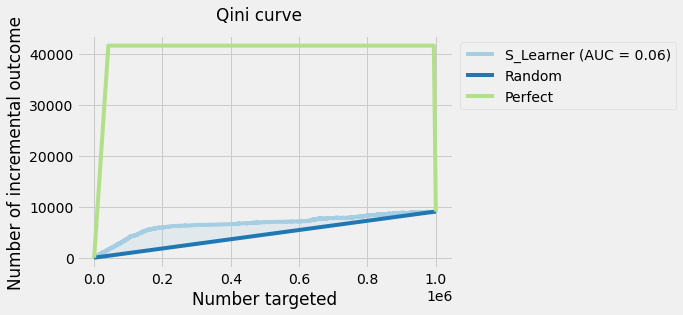

In [ ]:
qini_disp = plot_qini_curve(
    y_test_, uplift_effect_s, treatment_test_,
    perfect=True, name='S_Learner'
);

qini_disp.figure_.suptitle("Qini curve");

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


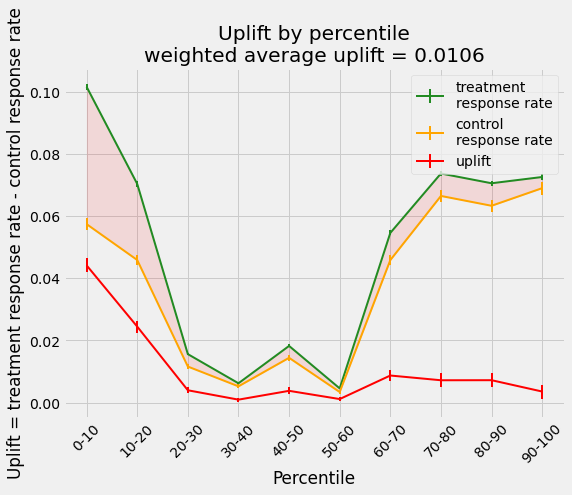

In [ ]:
uplift_percentile = plot_uplift_by_percentile(
    y_test_, uplift_effect_s, treatment_test_, strategy='overall'
)

### Meta Learner: T-Learner a.k.a Two Models

In [ ]:
class TLearnerModel:
    
    def __init__(self, classification_model):
        self.model_treatment_0 = clone(classification_model)
        self.model_treatment_1 = clone(classification_model)
    
    def fit(self, X_train, treatment_train, y_train):
        X_train_treatment_0 = X_train[treatment_train == 0]
        y_train_treatment_0 = y_train[treatment_train == 0]
        self.model_treatment_0.fit(X_train_treatment_0, y_train_treatment_0)
        
        X_train_treatment_1 = X_train[treatment_train == 1]
        y_train_treatment_1 = y_train[treatment_train == 1]
        self.model_treatment_1.fit(X_train_treatment_1, y_train_treatment_1)
        
    def predict(self, X_test):
        """return uplift effect array"""
        preds_treatment_0 = self.model_treatment_0.predict_proba(X_test)[:, 1]
        preds_treatment_1 = self.model_treatment_1.predict_proba(X_test)[:, 1]
        return preds_treatment_1 - preds_treatment_0

In [ ]:
estimator = XGBClassifier(
    random_state = 1,
    n_jobs = -1,
    eval_metric = 'logloss'
)

ul_model = TLearnerModel(estimator)
ul_model.fit(X_train[list(X_train.columns[:12])], treatment_train, y_train)
uplift_effect_t = ul_model.predict(X_test_)
get_metrics(y_val = y_test_, uplift_effect = uplift_effect_t, treatment_val = treatment_test_)

Model predicts positive effect in visit probability after treatment for 47.07% of cases.
Model predicts negative effect in visit probability after treatment for 52.93% of cases.
Model predicts no effect in visit probability after treatment for 0.0% of cases.
uplift at top 30% by group: 0.019 by overall: 0.019
 Weighted average uplift by group: 0.011 by overall: 0.010
 AUUC by group: 0.010
 AUQC by group: 0.025



Text(0.5, 0.98, 'Qini curve')

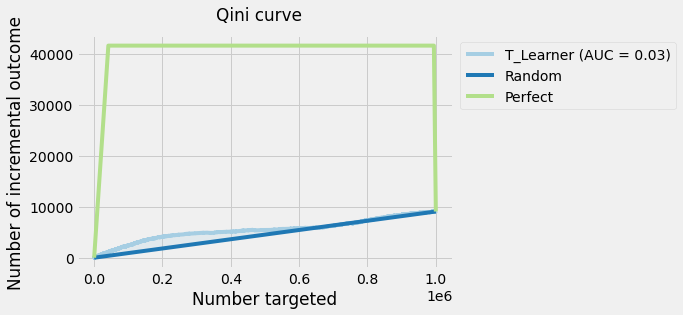

In [ ]:
qini_disp = plot_qini_curve(
    y_test_, uplift_effect_t, treatment_test_,
    perfect=True, name='T_Learner'
)

qini_disp.figure_.suptitle("Qini curve")

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


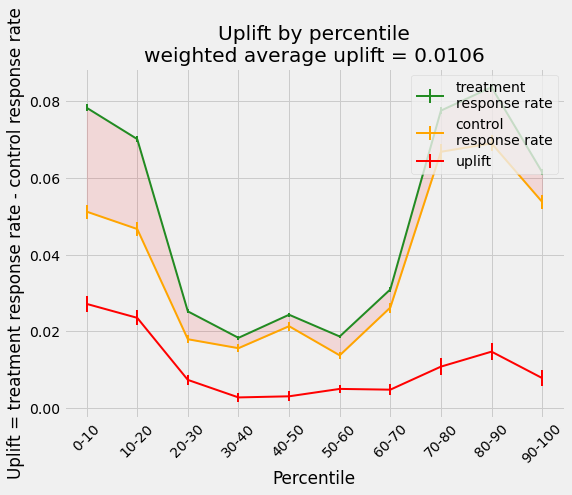

In [ ]:
uplift_percentile = plot_uplift_by_percentile(
    y_test_, uplift_effect_t, treatment_test_, strategy='by_group'
)

### Uplift Tree

In [ ]:
treat_vals_dict = {'0':'control', '1':'treated'}
treatment_train_str = treatment_train.astype('str').map(treat_vals_dict)
treatment_test_str = treatment_test.astype('str').map(treat_vals_dict)
treatment_train_str[:5]

8286668     control
6608205     control
6212244     control
8255270     control
13003024    control
Name: treatment, dtype: object

In [ ]:
ul_model = UpliftTreeClassifier(control_name='control', random_state = 1)
ul_model.fit(X_train.values, treatment_train_str.values, y_train.values)
trealment_0_pred = ul_model.predict(X_test_.values)[:, 0]
trealment_1_pred = ul_model.predict(X_test_.values)[:, 1]
uplift_effect_tree = trealment_1_pred - trealment_0_pred
get_metrics(y_val = y_test_, uplift_effect = uplift_effect_tree, treatment_val = treatment_test_)

Model predicts positive effect in visit probability after treatment for 17.53% of cases.
Model predicts negative effect in visit probability after treatment for 82.47% of cases.
Model predicts no effect in visit probability after treatment for 0.0% of cases.
uplift at top 30% by group: 0.031 by overall: 0.030
 Weighted average uplift by group: 0.011 by overall: 0.010
 AUUC by group: 0.029
 AUQC by group: 0.074



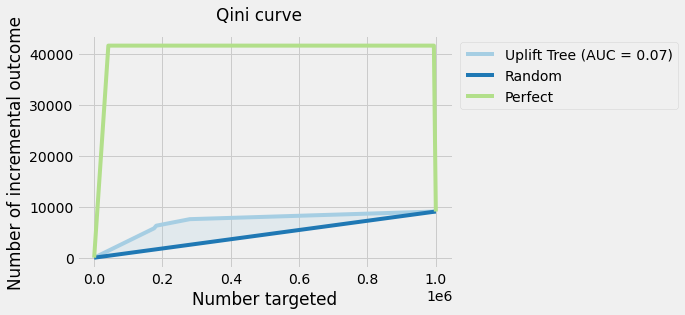

In [ ]:
qini_disp = plot_qini_curve(
    y_test_, uplift_effect_tree, treatment_test_,
    perfect=True, name='Uplift Tree'
);

qini_disp.figure_.suptitle("Qini curve");

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


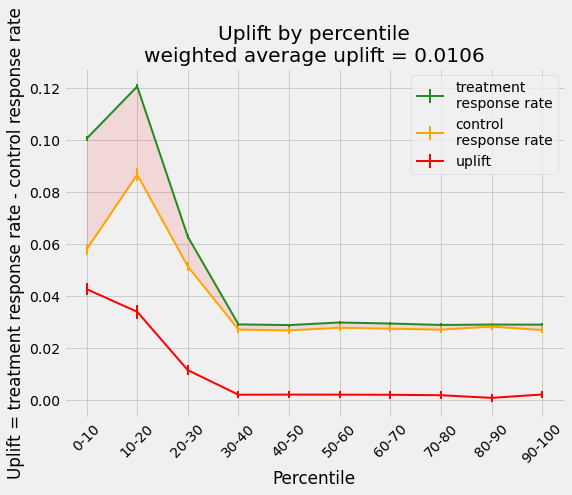

In [ ]:
uplift_percentile = plot_uplift_by_percentile(
    y_test_, uplift_effect_tree, treatment_test_, strategy='overall'
)

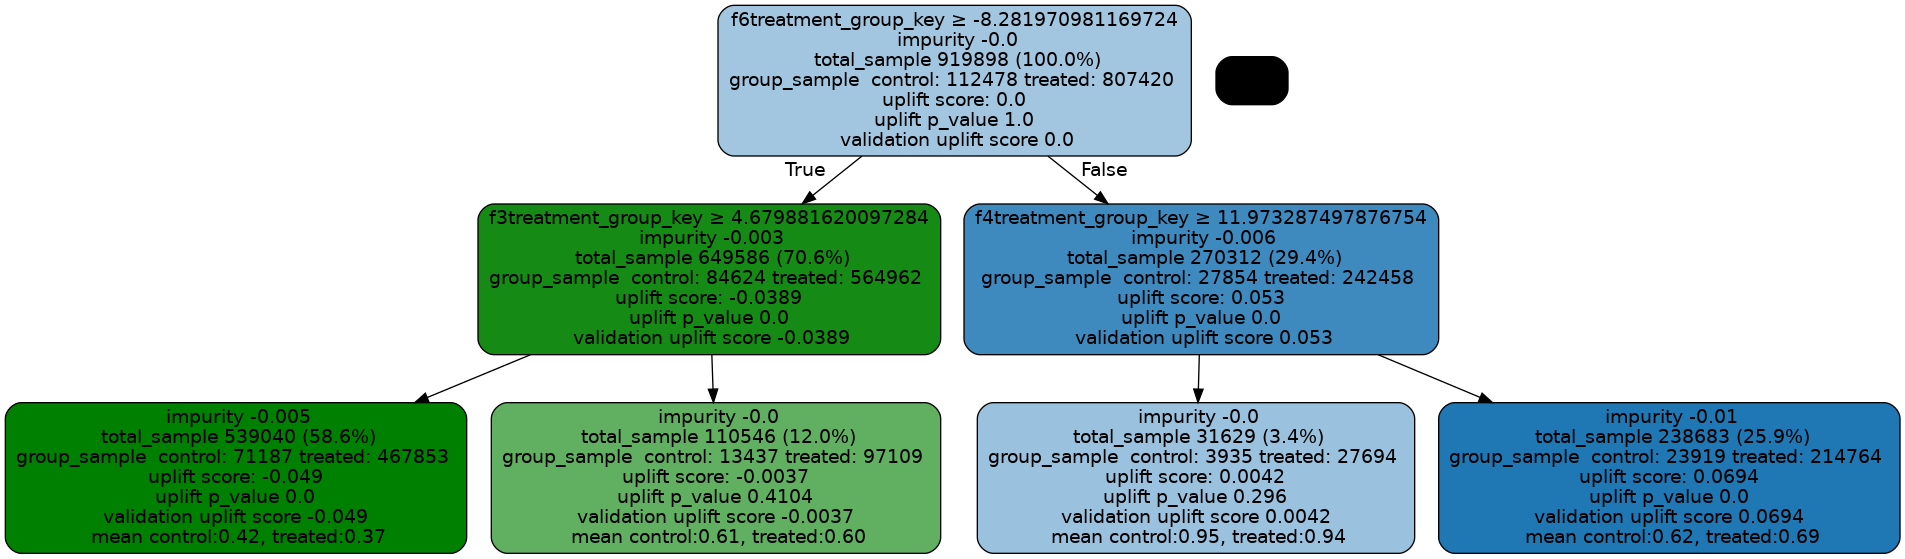

In [ ]:
graph = uplift_tree_plot(ul_model.fitted_uplift_tree, X_train.columns)
Image(graph.create_png())

### CEVAE Neural Network

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import entropy
import warnings
import logging

from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.inference.nn import CEVAE
from causalml.propensity import ElasticNetPropensityModel
from causalml.metrics import *
from causalml.dataset import simulate_hidden_confounder

%matplotlib inline
import torch

In [ ]:
# cevae model settings
outcome_dist = "normal"
latent_dim = 20
hidden_dim = 200
num_epochs = 5
batch_size = 1000
learning_rate = 1e-4
learning_rate_decay = 0.01
num_layers = 4

In [ ]:
cevae = CEVAE(outcome_dist=outcome_dist,
              latent_dim=latent_dim,
              hidden_dim=hidden_dim,
              num_epochs=num_epochs,
              batch_size=batch_size,
              learning_rate=learning_rate,
              learning_rate_decay=learning_rate_decay,
              num_layers=num_layers)

In [ ]:
# fit
losses = cevae.fit(X=torch.tensor(X_train.values, dtype=torch.float),
                   treatment=torch.tensor(treatment_train.values, dtype=torch.float),
                   y=torch.tensor(y_train.values, dtype=torch.float))

INFO 	 Training with 920 minibatches per epoch
DEBUG 	 step     0 loss = 24.7347
DEBUG 	 step   100 loss = 13.4119
DEBUG 	 step   200 loss = 3.96639
DEBUG 	 step   300 loss = 2.96345
DEBUG 	 step   400 loss = 0.593637
DEBUG 	 step   500 loss = 1.24416
DEBUG 	 step   600 loss = -0.201064
DEBUG 	 step   700 loss = -0.89705
DEBUG 	 step   800 loss = -1.62966
DEBUG 	 step   900 loss = 0.000701861
DEBUG 	 step  1000 loss = -1.22976
DEBUG 	 step  1100 loss = -1.41825
DEBUG 	 step  1200 loss = -2.9397
DEBUG 	 step  1300 loss = -3.37831
DEBUG 	 step  1400 loss = -0.0637857
DEBUG 	 step  1500 loss = -3.0042
DEBUG 	 step  1600 loss = -3.54827
DEBUG 	 step  1700 loss = -3.15569
DEBUG 	 step  1800 loss = -1.16641
DEBUG 	 step  1900 loss = -2.8423
DEBUG 	 step  2000 loss = -3.67109
DEBUG 	 step  2100 loss = -2.56054
DEBUG 	 step  2200 loss = 0.959373
DEBUG 	 step  2300 loss = -0.434707
DEBUG 	 step  2400 loss = -3.6876
DEBUG 	 step  2500 loss = -4.61969
DEBUG 	 step  2600 loss = -4.74434
DEBUG 	 st

In [ ]:
# predict
#ite_train = cevae.predict(X_train.values)
uplift_effect = cevae.predict(torch.tensor(X_test_.values, dtype=torch.float))

INFO 	 Evaluating 1000 minibatches
DEBUG 	 batch ate = -0.0398503
DEBUG 	 batch ate = -0.0422744
DEBUG 	 batch ate = -0.0393599
DEBUG 	 batch ate = -0.0404435
DEBUG 	 batch ate = -0.038351
DEBUG 	 batch ate = -0.0390497
DEBUG 	 batch ate = -0.0403462
DEBUG 	 batch ate = -0.0396495
DEBUG 	 batch ate = -0.0383208
DEBUG 	 batch ate = -0.0390641
DEBUG 	 batch ate = -0.0383025
DEBUG 	 batch ate = -0.0404118
DEBUG 	 batch ate = -0.0409781
DEBUG 	 batch ate = -0.0371292
DEBUG 	 batch ate = -0.0387175
DEBUG 	 batch ate = -0.0398162
DEBUG 	 batch ate = -0.0393437
DEBUG 	 batch ate = -0.0378492
DEBUG 	 batch ate = -0.0413254
DEBUG 	 batch ate = -0.0384998
DEBUG 	 batch ate = -0.0386644
DEBUG 	 batch ate = -0.0396123
DEBUG 	 batch ate = -0.0400094
DEBUG 	 batch ate = -0.0406255
DEBUG 	 batch ate = -0.0385974
DEBUG 	 batch ate = -0.0395249
DEBUG 	 batch ate = -0.0390895
DEBUG 	 batch ate = -0.0403977
DEBUG 	 batch ate = -0.0401953
DEBUG 	 batch ate = -0.0393816
DEBUG 	 batch ate = -0.0407012
DEBUG

In [ ]:
get_metrics(y_val = y_test_, uplift_effect = uplift_effect, treatment_val = treatment_test_)

Model predicts positive effect in visit probability after treatment for 10.46% of cases.
Model predicts negative effect in visit probability after treatment for 89.54% of cases.
Model predicts no effect in visit probability after treatment for 0.0% of cases.
uplift at top 30% by group: 0.023 by overall: 0.022
 Weighted average uplift by group: 0.011 by overall: 0.010
 AUUC by group: 0.020
 AUQC by group: 0.051



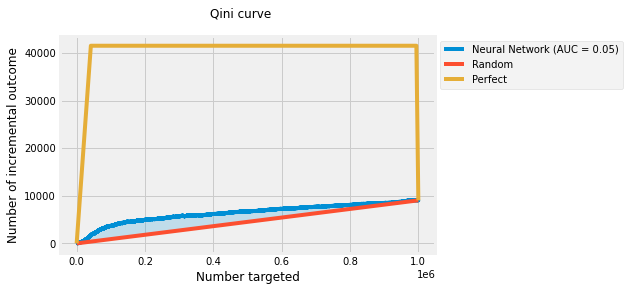

In [ ]:
qini_disp = plot_qini_curve(
    y_test_, uplift_effect, treatment_test_,
    perfect=True, name='Neural Network'
);

qini_disp.figure_.suptitle("Qini curve");

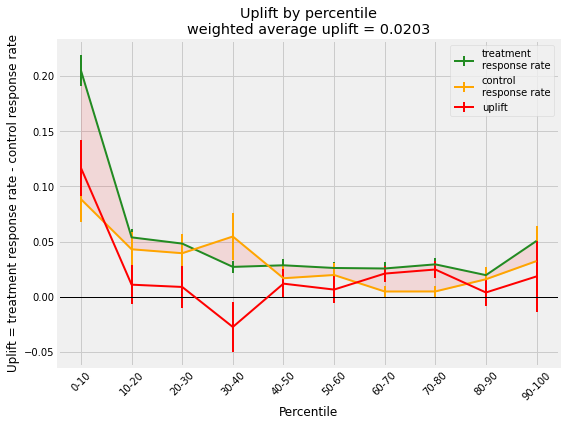

In [ ]:
uplift_percentile = plot_uplift_by_percentile(
    y_test_, uplift_effect, treatment_test_, strategy='overall'
)

### Results & Comparision

In [ ]:
def get_metrics_viz(y_val, uplift_effect, treatment_val):
    no_effect_share = round(100 * np.sum(uplift_effect == 0) / len(uplift_effect), 2)
    positive_effect_share = round(100 * np.sum(uplift_effect > 0) / len(uplift_effect), 2)
    negative_effect_share = round(100 * np.sum(uplift_effect < 0) / len(uplift_effect), 2)
    #print(f'Model predicts positive effect in visit probability after treatment for {positive_effect_share}% of cases.')
    #print(f'Model predicts negative effect in visit probability after treatment for {negative_effect_share}% of cases.')
    #print(f'Model predicts no effect in visit probability after treatment for {no_effect_share}% of cases.')

    upliftk = uplift_at_k(
        y_true = y_val, 
        uplift = uplift_effect, 
        treatment = treatment_val, 
        strategy='by_group', 
        k = 0.3
    )
    
    upliftk_all = uplift_at_k(
        y_true = y_val, 
        uplift = uplift_effect, 
        treatment = treatment_val, 
        strategy = 'overall',
    )

    qini_coef = qini_auc_score(
        y_true = y_val, 
        uplift = uplift_effect,
        treatment = treatment_val
    )

    uplift_auc = uplift_auc_score(
        y_true = y_val, 
        uplift = uplift_effect,
        treatment = treatment_val
    )
    wau = weighted_average_uplift(y_true = y_val, uplift = uplift_effect,
                                  treatment = treatment_val, strategy = 'by_group')
    
    wau_all = weighted_average_uplift(y_true = y_val, uplift = uplift_effect,
                                  treatment = treatment_val, strategy = 'overall')

    return f'uplift at top 30% by group: {upliftk:.3f} by overall: {upliftk_all:.3f}\n' + f'Weighted average uplift by group: {wau:.3f} by overall: {wau_all:.3f}\n' + f'AUUC by group: {uplift_auc:.3f}\n' + f'AUQC by group: {qini_coef:.3f}\n'

Metrics for evaluating uplift are more complex than typical metrics used in supervised learning, such as the ROC AUC. This is because it is not possible to observe both the control and the treatment outcomes for a given individual at the same time, which makes it dicult to find a loss measure. One way to measure uplift is using a Qini curve (Radcliffe, 2007).

The Qini curve shows the cumulative number of the incremental positive outcomes or uplift as a function of the number of customers treated. A more performant model can distinguish individuals with positive outcomes from individuals with negative outcomes, yielding a larger separation between the curve and the diagonal, which would represent a random targeting strategy.

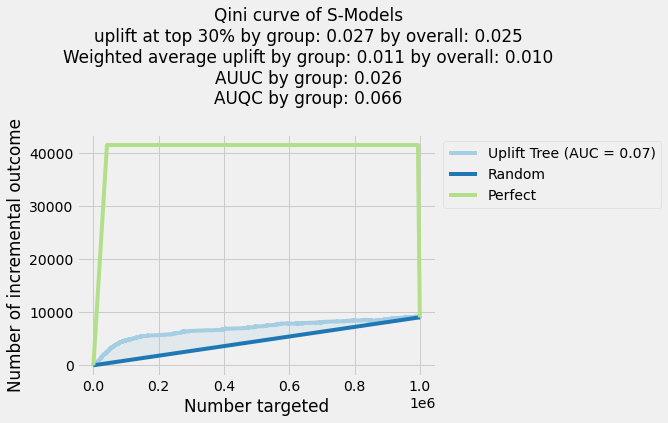

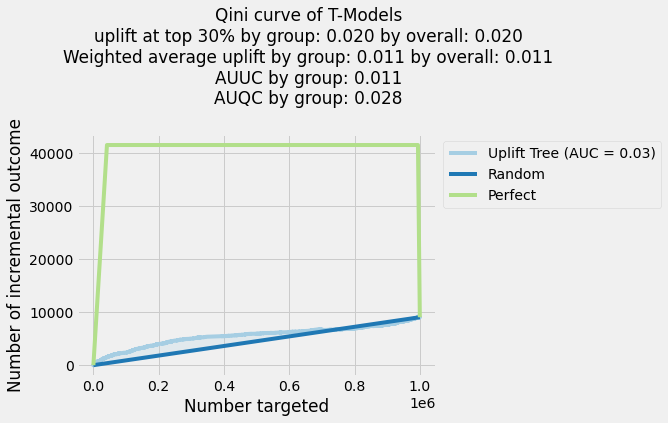

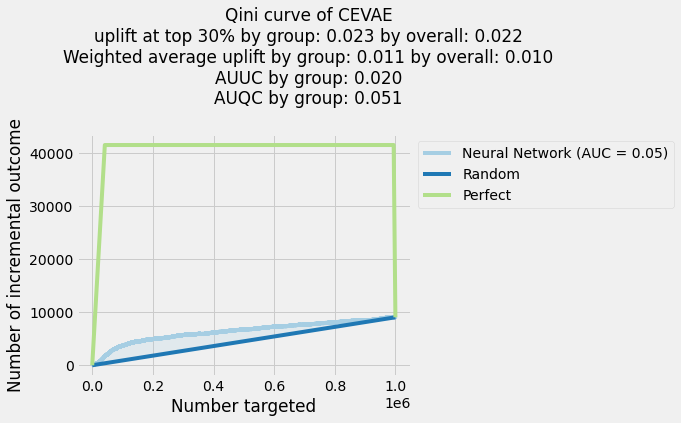

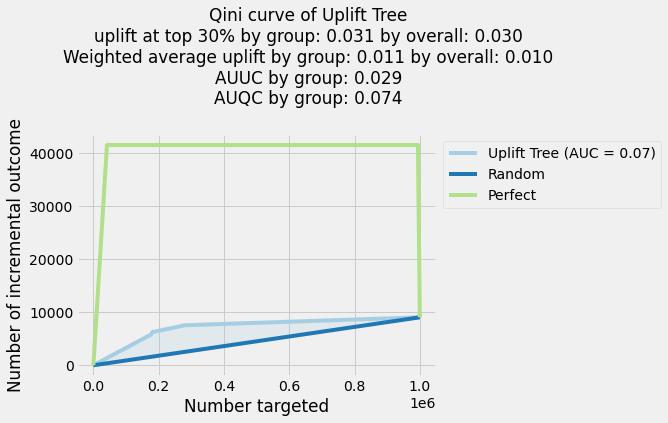

In [ ]:
qini_disp_s = plot_qini_curve(
    y_test_, uplift_effect_s, treatment_test_,
    perfect=True, name='Uplift Tree'
);

qini_disp_s.figure_.suptitle("Qini curve of S-Models\n" + get_metrics_viz(y_val = y_test_, uplift_effect = uplift_effect_s, treatment_val = treatment_test_));
qini_disp_s.figure_.tight_layout(rect=[0, 0.03, 1, 0.95])
qini_disp_s.figure_.set_figheight(6)
qini_disp_s.figure_.set_figwidth(8)

qini_disp_t = plot_qini_curve(
    y_test_, uplift_effect_t, treatment_test_,
    perfect=True, name='Uplift Tree'
);

qini_disp_t.figure_.suptitle("Qini curve of T-Models\n" + get_metrics_viz(y_val = y_test_, uplift_effect = uplift_effect_t, treatment_val = treatment_test_));
qini_disp_t.figure_.tight_layout(rect=[0, 0.03, 1, 0.95])
qini_disp_t.figure_.set_figheight(6)
qini_disp_t.figure_.set_figwidth(8)

qini_disp_nn = plot_qini_curve(
    y_test_, uplift_effect, treatment_test_,
    perfect=True, name='Neural Network'
);

qini_disp_nn.figure_.suptitle("Qini curve of CEVAE\n" + get_metrics_viz(y_val = y_test_, uplift_effect = uplift_effect, treatment_val = treatment_test_));
qini_disp_nn.figure_.tight_layout(rect=[0, 0.03, 1, 0.95])
qini_disp_nn.figure_.set_figheight(6)
qini_disp_nn.figure_.set_figwidth(8)

qini_disp_tree = plot_qini_curve(
    y_test_, uplift_effect_tree, treatment_test_,
    perfect=True, name='Uplift Tree'
);

qini_disp_tree.figure_.suptitle("Qini curve of Uplift Tree\n" + get_metrics_viz(y_val = y_test_, uplift_effect = uplift_effect_tree, treatment_val = treatment_test_));
qini_disp_tree.figure_.tight_layout(rect=[0, 0.03, 1, 0.95])
qini_disp_tree.figure_.set_figheight(6)
qini_disp_tree.figure_.set_figwidth(8)

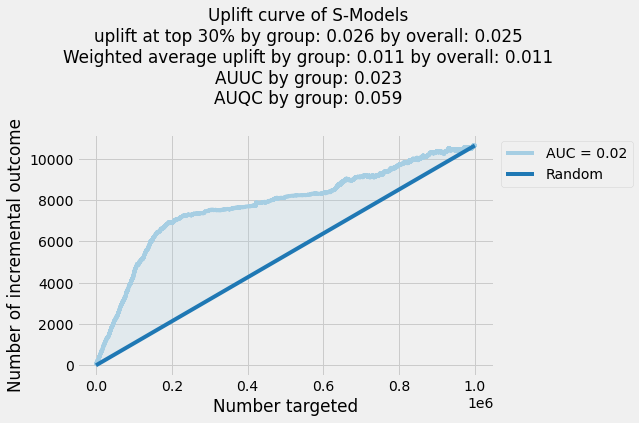

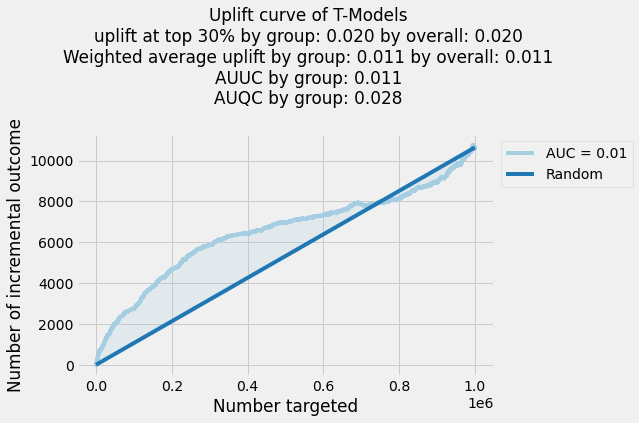

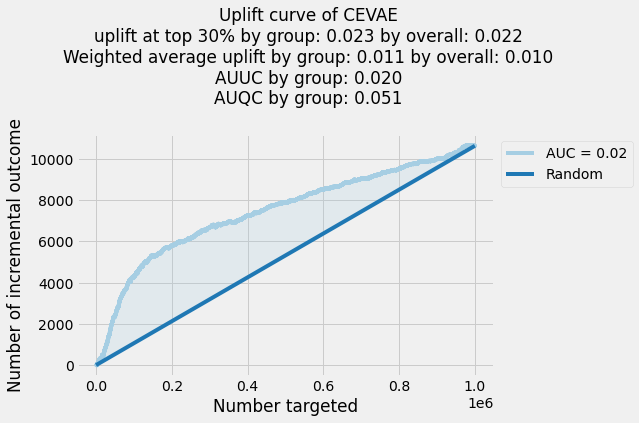

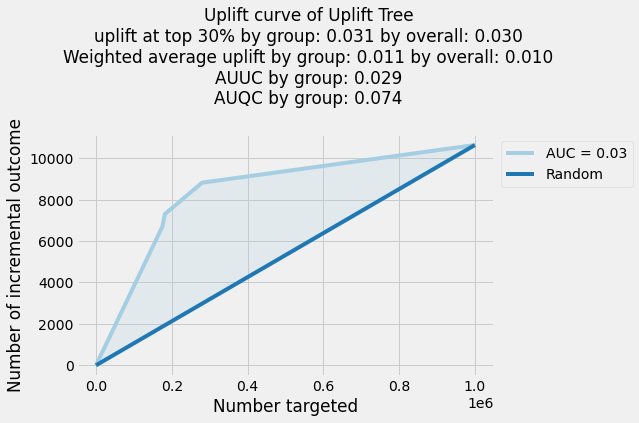

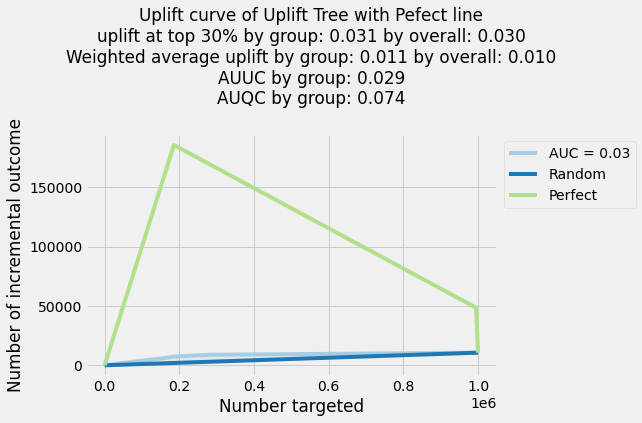

In [ ]:
k = plot_uplift_curve(y_test_, uplift_effect_s, treatment_test_, perfect = False)
k.figure_.suptitle("Uplift curve of S-Models\n" + get_metrics_viz(y_val = y_test_, uplift_effect = uplift_effect_s, treatment_val = treatment_test_));
k.figure_.tight_layout(rect=[0, 0.03, 1, 0.95])
k.figure_.set_figheight(6)
k.figure_.set_figwidth(8)

k = plot_uplift_curve(y_test_, uplift_effect_t, treatment_test_, perfect = False)
k.figure_.suptitle("Uplift curve of T-Models\n" + get_metrics_viz(y_val = y_test_, uplift_effect = uplift_effect_t, treatment_val = treatment_test_));
k.figure_.tight_layout(rect=[0, 0.03, 1, 0.95])
k.figure_.set_figheight(6)
k.figure_.set_figwidth(8)

k = plot_uplift_curve(y_test_, uplift_effect, treatment_test_, perfect = False)
k.figure_.suptitle("Uplift curve of CEVAE\n" + get_metrics_viz(y_val = y_test_, uplift_effect = uplift_effect, treatment_val = treatment_test_));
k.figure_.tight_layout(rect=[0, 0.03, 1, 0.95])
k.figure_.set_figheight(6)
k.figure_.set_figwidth(8)

k = plot_uplift_curve(y_test_, uplift_effect_tree, treatment_test_, perfect = False)
k.figure_.suptitle("Uplift curve of Uplift Tree\n" + get_metrics_viz(y_val = y_test_, uplift_effect = uplift_effect_tree, treatment_val = treatment_test_));
k.figure_.tight_layout(rect=[0, 0.03, 1, 0.95])
k.figure_.set_figheight(6)
k.figure_.set_figwidth(8)

k = plot_uplift_curve(y_test_, uplift_effect_tree, treatment_test_)
k.figure_.suptitle("Uplift curve of Uplift Tree with Pefect line\n" + get_metrics_viz(y_val = y_test_, uplift_effect = uplift_effect_tree, treatment_val = treatment_test_));
k.figure_.tight_layout(rect=[0, 0.03, 1, 0.95])
k.figure_.set_figheight(6)
k.figure_.set_figwidth(8)

The plot gain indicates the fraction of population needs to be treated in order to reach an amount of visiting number. In the chart, we can see that the Uplift Tree line suggests that it only needs to target about ~0.27 of the sampling population (270.000 over 1.000.000) to reach about 9000 (90% of 10.000) visits.

## **Predictive Modeling**

Perform a predictive modeling technique to later compare 2 methods

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
X_train_pred = X_train
X_train_pred['treatment'] = treatment_train
X_test_pred = X_test_ 
X_test_pred['treatment'] = treatment_test_

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train_pred, y_train)
y_pred = logreg.predict(X_test_pred)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test_pred, y_test_)))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Accuracy of logistic regression classifier on test set: 0.89


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_, y_pred)
print(cm)

[[849327 103404]
 [  8890  38379]]


In [ ]:
prb=logreg.predict_proba(X_test_pred)[:,1]
type(prb)

numpy.ndarray

## **Compare results: Predictive vs Prescriptive**

For comparison between 2 methods, we will use the Cummulative Gain and the Lift Curve visualizations

### Cummulative gain

In [ ]:
### Load saved uplift effect (if only run this part without go through the parts above
uplift_effect_s = np.load('uplift_effect_s.npy')
uplift_effect_t = np.load('uplift_effect_t.npy')
uplift_effect_tree = np.load('uplift_effect_tree.npy')
uplift_effect = np.load('uplift_effect.npy')

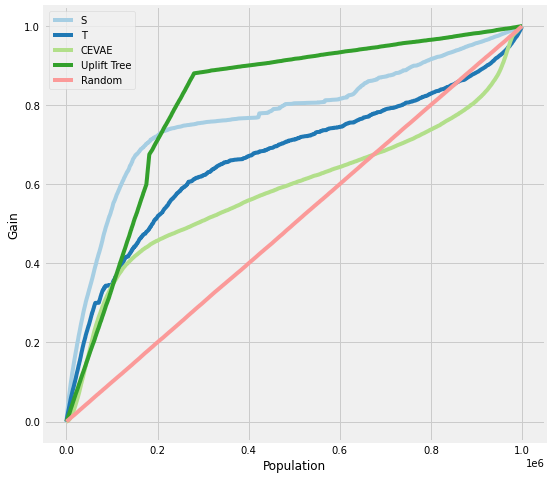

In [ ]:
df_preds = pd.DataFrame([uplift_effect_s.ravel(),
                               uplift_effect_t.ravel(),
                               uplift_effect.ravel(),
                               uplift_effect_tree.ravel(),
                               exposure_test_.ravel(),
                               treatment_test_.ravel(),
                               y_test_.ravel()],
                               index=['S','T','CEVAE','Uplift Tree','tau','w','y']).T
plot_gain(df_preds, n = 1000000, normalize = True )

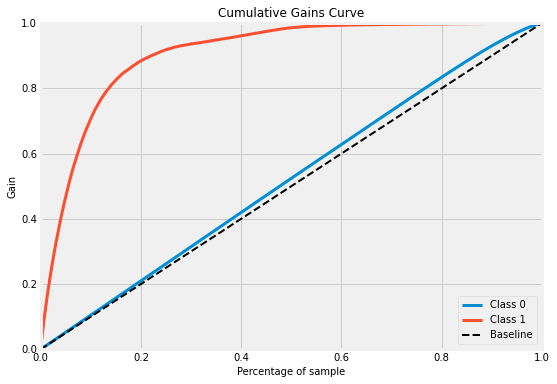

In [ ]:
import scikitplot as skplt

plt = skplt.metrics.plot_cumulative_gain(y_test_, logreg.predict_proba(X_test_pred), figsize = (8,6))

Considering the Uplift Tree method versus the Response Modeling, both method' gain plots implies that the top 27% with the highest predicted probabilities contain approximately 90% of the rweb visitors (our y).

**IMPORTANT NOTE**: The cummulative gain curve of Response Modeling and Uplift Modeling is the same in terms of the idea and way to read the graph. However, noted that those 2 curves are **different** in the scale and implementation. 

The cummulative gain curve of Response/Predictive modeling show the cummulative probability, where its maximum cummulative is always equal the number of the true positive target label (for example visit = 1 a.k.a customer did visit the site). For example, Gain = 1 indicates that the curve reached all of the true positive target samples (about 40.500) within the population samples.

Meanwhile, the cummulative gain curve of Uplift modeling show the cummulative gain, which is equal to (the number of population samples) * (lift score). Thus, the maximum cummulative is the number of positive target label that the uplift model can reach. For example, Gain = 1 indicates that the curve reached all of the positive target that the uplift can reccomend (about 31.000).

In this case, if we put those 2 gain curves into a graph, it will look like this:

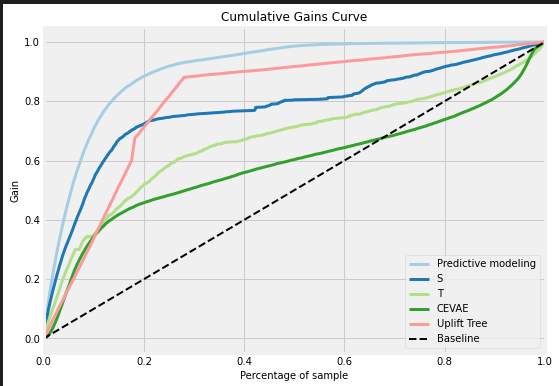

By looking at this graph, seems like Predictive modeling beats Uplift modeling, which is possible if the sample we choose contains mostly customers from Persuasive group.

Once again, however, as mentioned above, comparing Response and Uplift using Cummulative Gain might not be correct, and might need further investigation.

### Lift curve

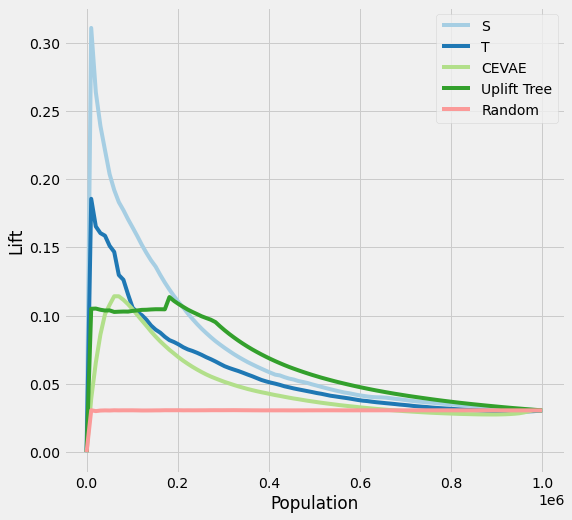

In [ ]:
plot_lift(df_preds)

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

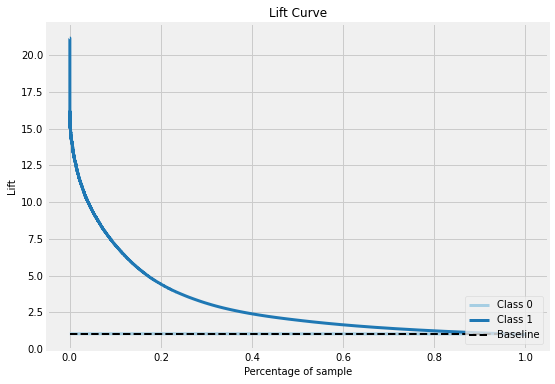

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_lift_curve(y_test_, logreg.predict_proba(X_test_pred), figsize = (8,6))

The lift curve of the Uplift Modeling stated that about 20% of the population given treatment by Uplift can give us extra 10% lift compared to random treatment. Meanwhile, the lift curve of Predictive Modeling stated that about 20% of the population given treatment by predictive model can give us extra 4.5% compared to random treatment. 

This implies that Uplift Modeling may have better effect for lifting compared to predictive modeling! However, just like what I noted in the Cummulative gain curve comparison above, the 2 lift curve may have different scales and might need further investigation. This is for reference only!

## **Comment & Conclusion**

Several notes during my implementation for this demo:

* Run too long for X-Learner, R-Learner, and Neural Network: It took lots of time to compute the propensity score for X-Learner & R-Learner. Also, even with GPU, the CEVAE took lots of time to calculate the ATE and ITE with 1,000,000 samples.
* The result for CEVAE is non-deterministic.
* The current Python libraries, including both Sklift and CausalMl, contain many bugs which made me super offended during implementation. The documentations of those libraries are also very suck and outdated. 
* CausalML and Sklift has different implementation -> return different results. While the result of CausalML seemed to be deterministic throughout different run, the result of SKlift seemed to be non-deterministic.
* There are very few research on how to compare Uplift and other markering Modeling such as Response/Predictive or Lookalike model! Need further investigation!


The libraries, documentations, and support community for the Uplift Modeling is very limited (compared to other ML fields): very few implementation and discussion related to this aspect. Lots of unsolved bugs and outdated content. Therefore, if we want to implement Uplift Modeling, we should:
* Recheck all of the source code
* Should implement by ourselves

References:
* https://scikit-plot.readthedocs.io/en/stable/metrics.html
* https://causalml.readthedocs.io/en/latest/causalml.html#causalml.metrics.plot_gain
* https://www.kaggle.com/code/max398434434/marketing-campaign-uplift-modeling/notebook
* https://www.kaggle.com/code/hughhuyton/criteo-uplift-modelling
* https://github.com/uber/causalml/blob/master/examples/cevae_example.ipynb